# Learning to Predict by the Methods of Temporal Differences

## Background

### Theory
observation-outcome sequence: $x_1, x_2, x_3, \ldots, x_m, z$

Prediction: $P\left(x_t, w\right)$

for each sequence, produce prediction $P_1, P_2, P_3, \ldots, P_m$

Update:

$$w \leftarrow w+\sum_{t=1}^m \Delta w_t$$

$\mathrm{TD(1)}$:

$z-P_t=\sum_{k=t}^m\left(P_{k+1}-P_k\right) \quad$ where $\quad P_{m+1} \stackrel{\text { def }}{=} z$

therefore

$$\begin{aligned} w \leftarrow w+\sum_{t=1}^m \alpha\left(z-P_t\right) \nabla_w P_t & =w+\sum_{t=1}^m \alpha \sum_{k=t}^m\left(P_{k+1}-P_k\right) \nabla_w P_t \\ & =w+\sum_{k=1}^m \alpha \sum_{t=1}^k\left(P_{k+1}-P_k\right) \nabla_w P_t \\ & =w+\sum_{t=1}^m \alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \nabla_w P_k\end{aligned}$$

or:

$$\Delta w_t=\alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \nabla_w P_k$$

$\mathrm{TD(\lambda)}$:

Consider an exponential decayed weighting with recency:

$$\Delta w_t=\alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \lambda^{t-k} \nabla_w P_k$$

def: $\quad e_t$ = $\sum_{k=1}^t \lambda^{t-k} \nabla_w P_k$

then: $\quad e_{t+1} = \lambda e_t + \nabla_w P_{t+1}$

### Bounded Random Walk
All walks begin in state $D$. From states $B$, $C, D, E$, and $F$, the walk has a $50-50$ chance of moving either to the right or to the left. If either edge state, $A$ or $G$, is entered, then the walk terminates. We wish to estimate the probabilities of a walk ending in the rightmost state, $G$, given that it is in each of the other states.

![bounded_random_walk.png](https://s2.loli.net/2024/03/20/ri3gvmLDYMKnc2T.png)

- State value function:

    For each non-terminal state $i$, there was a corresponding observation vector $\mathbf{x}_i$; if the walk was in state $i$ at time $t$ then $x_t=\mathbf{x}_i$.

    In this case, the vectors $\left\{\mathbf{x}_i\right\}$ were the **unit basis vectors** of length 5.

    $P_t=w^T x_t = w_i$

## Experiment 1

- $w$ updated only after the **complete** presentation of a training set
- Each training set was presented repeatedly until convergence.

In [1]:
import numpy as np
from alive_progress import alive_it

random_seed = 42
np.random.seed(random_seed)
# start at D
start_pos = 2
# training sets
batch = 100
batch_size = 10
# theoretical probability
P_ideal = np.array([1/6, 1/3, 1/2, 2/3, 5/6])

lambdas = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

def prediction(w, current_pos):
    return w[current_pos]

def state_value(w, current_pos):
    if current_pos == -1:
        return 0
    elif current_pos == 5:
        return 1
    else:
        return prediction(w, current_pos)

def update_weights(w, current_pos, next_pos, alpha, lamb, e):
    delta_e = np.zeros(5)
    delta_e[current_pos] = 1
    e = lamb * e + delta_e
    delta_w = alpha * (state_value(w, next_pos) - state_value(w, current_pos)) * e
    return delta_w, e

### Data generation

In [2]:
def generate_sequence(start_pos = 2):
    current_pos = start_pos
    sequence = [current_pos]
    while True:
        action = np.random.choice([-1,1])
        current_pos += action
        sequence.append(current_pos)
        if current_pos == -1 or current_pos == 5:
            return sequence

def generate_data(batch, batch_size):
    data = []
    for i in range(batch):
        batch_data = []
        for j in range(batch_size):
            batch_data.append(generate_sequence())
        data.append(batch_data)
    return data

data = generate_data(batch, batch_size)

In [3]:
import random
random.sample(data[0], 3)

[[2, 1, 2, 1, 0, -1], [2, 1, 0, -1], [2, 3, 4, 3, 4, 5]]

In [4]:
def rms_error(batch, w, P_ideal):
    err = 0
    for sequence in batch:
        err_list = []
        for x in sequence[:-1]:
            err_list.append(prediction(w, x) - P_ideal[x])
        err += np.sqrt(np.mean(np.square(err_list)))

    err /= len(batch)

    return err

def train(data, alpha, lamb,convergence_threshold):

    # initialize weights
    err = 0
    for batch in alive_it(data):
        w = np.random.uniform(0,1,5)

        while True:
            delta_w = np.zeros(5)
            for sequence in batch:
                e = 0
                for idx in range(len(sequence)-1):
                    res =  update_weights(w, sequence[idx], sequence[idx+1], alpha, lamb, e)
                    delta_w += res[0]
                    e = res[1]
            w += delta_w
            if np.linalg.norm(delta_w) < convergence_threshold:
                err += rms_error(batch, w, P_ideal)
                break
    err /= len(data)

    return err

|████████████████████████████████████████| 100/100 [100%] in 1.1s (91.95/s) 
|████████████████████████████████████████| 100/100 [100%] in 1.0s (102.70/s) 
|████████████████████████████████████████| 100/100 [100%] in 0.9s (107.34/s) 
|████████████████████████████████████████| 100/100 [100%] in 0.9s (108.55/s) 
|████████████████████████████████████████| 100/100 [100%] in 0.9s (111.01/s) 
|████████████████████████████████████████| 100/100 [100%] in 0.8s (127.52/s) 
|████████████████████████████████████████| 100/100 [100%] in 0.8s (120.12/s) 


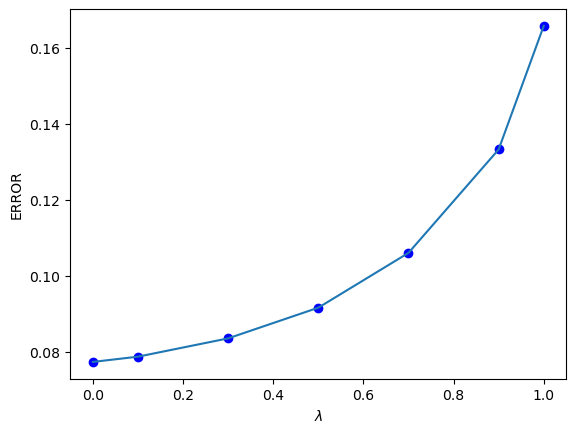

In [12]:
import matplotlib.pyplot as plt

def plot_rms_error(lambdas, alpha, data,convergence_threshold):
    rms_errors = []
    for lamb in lambdas:
        err = train(data, alpha, lamb,convergence_threshold)
        rms_errors.append(err)
    plt.plot(lambdas, rms_errors)
    plt.xlabel('$\lambda$')
    plt.ylabel('ERROR')
    plt.scatter(lambdas, rms_errors, color='b')
    plt.show()

# hyperparams
alpha = 0.01
convergence_threshold = 0.01
plot_rms_error(lambdas, alpha, data,convergence_threshold)

### problems/pitfalls during research
- Trouble understanding when to update $w$ and repeatedly present training sets.
- Need careful selection of (especially)learning rate and convergence conditions!
- WTF is this RMS metric??? -- Need to re-init weight w for every batch.

## Experiment 2
- same data
- each training set was presented once to each procedure
- weight updates were performed after each sequence
- all components of the weight vector were initially set to $0.5$

In [6]:
lrs = np.linspace(0, 0.6, 13)
lambdas_2 = [0.0, 0.3, 0.8, 1.0]
def train_2(data, alpha, lamb):

    # initialize weights to 0.5
    err = 0
    for batch in data:
        w = np.full(5, 0.5)
        for sequence in batch:
            delta_w = np.zeros(5)
            e = 0
            for idx in range(len(sequence)-1):
                res =  update_weights(w, sequence[idx], sequence[idx+1], alpha, lamb, e)
                delta_w += res[0]
                e = res[1]
            w += delta_w
        err += rms_error(batch, w, P_ideal)
    err /= len(data)

    return err


def plot_rms_error_2(lambdas_2, lrs, data):
    threshold = 0.8
    for lamb in lambdas_2:
        rms_errors = []
        for lr in alive_it(lrs):
            err = train_2(data, lr, lamb)
            if err > threshold:
                break
            rms_errors.append(err)
        plt.plot(lrs[:len(rms_errors)], np.array(rms_errors), label='$\lambda$ = ' + str(lamb))
        plt.scatter(lrs[:len(rms_errors)], np.array(rms_errors))
    plt.legend()
    plt.xlabel('α')
    plt.ylabel('ERROR')
    plt.show()

|██████████████████████████████▊⚠︎        | (!) 10/13 [77%] in 0.7s (14.42/s) 
|████████████████████████████████████▉⚠︎  | (!) 12/13 [92%] in 0.8s (15.77/s) 
|████████████████████████████████████▉⚠︎  | (!) 12/13 [92%] in 0.8s (15.38/s) 
|████████████████████████▋⚠︎              | (!) 8/13 [62%] in 0.5s (15.02/s) 


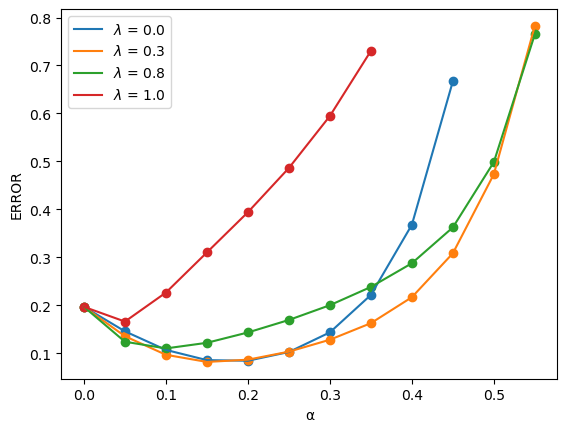

In [7]:
plot_rms_error_2(lambdas_2, lrs, data)

## Experiment 3
- Average error at best $\alpha$ value on random walk problem, selected from figure $4$

|████████████████████████████████████████| 13/13 [100%] in 0.8s (16.83/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.8s (16.82/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.8s (16.52/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.7s (17.52/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.8s (16.78/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.8s (16.56/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.7s (17.40/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.7s (17.38/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.7s (17.47/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.8s (16.52/s) 
|████████████████████████████████████████| 13/13 [100%] in 0.8s (17.14/s) 
The best lambda is around 0.3


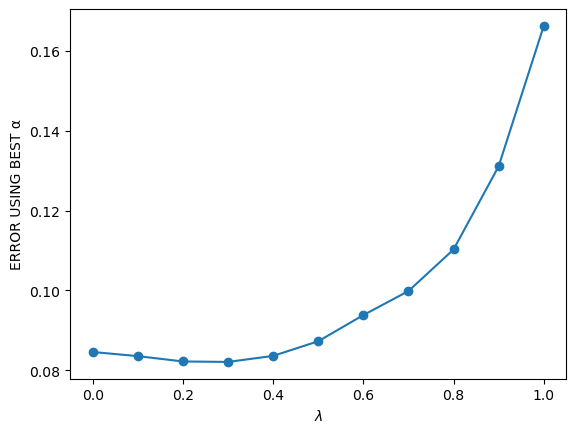

In [8]:
lambdas_3 = np.linspace(0, 1, 11)
def plot_rms_error_3(lambdas_3, lrs, data):
    err_list = []
    # choose lr that yields the least error for each lambda
    for lamb in lambdas_3:
        least_err = 1
        for lr in alive_it(lrs):
            err = train_2(data, lr, lamb)
            if err < least_err:
                least_err = err
        err_list.append(least_err)
    print('The best lambda is around', round(lambdas_3[np.argmin(err_list)],3))
    plt.plot(lambdas_3, err_list)
    plt.scatter(lambdas_3, err_list)
    plt.xlabel('$\lambda$')
    plt.ylabel('ERROR USING BEST α')
    plt.show()

plot_rms_error_3(lambdas_3, lrs, data)